In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

import warnings
warnings.filterwarnings("ignore")

/kaggle/input/tabular-playground-series-feb-2021/sample_submission.csv
/kaggle/input/tabular-playground-series-feb-2021/train.csv
/kaggle/input/tabular-playground-series-feb-2021/test.csv


In [3]:
# imports
from pandas_profiling import ProfileReport
# import needed modules
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns



### playing with catboost for tabular playground feb submission

In [4]:
train_data = pd.read_csv('/kaggle/input/tabular-playground-series-feb-2021/train.csv')
test_data = pd.read_csv('/kaggle/input/tabular-playground-series-feb-2021/test.csv')

print(train_data.head(), "\n")
print(test_data.head())



   id cat0 cat1 cat2 cat3 cat4 cat5 cat6 cat7 cat8  ...     cont5     cont6  \
0   1    A    B    A    A    B    D    A    E    C  ...  0.881122  0.421650   
1   2    B    A    A    A    B    B    A    E    A  ...  0.440011  0.346230   
2   3    A    A    A    C    B    D    A    B    C  ...  0.914155  0.369602   
3   4    A    A    A    C    B    D    A    E    G  ...  0.934138  0.578930   
4   6    A    B    A    A    B    B    A    E    C  ...  0.382600  0.705940   

      cont7     cont8     cont9    cont10    cont11    cont12    cont13  \
0  0.741413  0.895799  0.802461  0.724417  0.701915  0.877618  0.719903   
1  0.278495  0.593413  0.546056  0.613252  0.741289  0.326679  0.808464   
2  0.832564  0.865620  0.825251  0.264104  0.695561  0.869133  0.828352   
3  0.407313  0.868099  0.794402  0.494269  0.698125  0.809799  0.614766   
4  0.325193  0.440967  0.462146  0.724447  0.683073  0.343457  0.297743   

     target  
0  6.994023  
1  8.071256  
2  5.760456  
3  7.806457  
4  6

In [5]:
print(train_data.shape, "\n")
print(test_data.shape)


(300000, 26) 

(200000, 25)


In [6]:
auto_eda = ProfileReport(train_data, title="Tabular Data Series - Feb 2021: train data", explorative=True, minimal=False, progress_bar=False)
#auto_eda.to_notebook_iframe()

In [7]:
#test_data
auto_eda = ProfileReport(test_data, title="Tabular Data Series - Feb 2021: test data", explorative=True, minimal=False, progress_bar=False)
#auto_eda.to_notebook_iframe()

In [8]:
cat_features = ['cat0', 'cat1', 'cat2', 'cat3', 'cat4', 'cat5', 'cat6', 'cat7', 'cat8', 'cat9']
numerical_features = ['cont0', 'cont1', 'cont2', 'cont3', 'cont4', 'cont5','cont6', 'cont7', 'cont8', 'cont9', 'cont10', 'cont11', 'cont12', 'cont13']

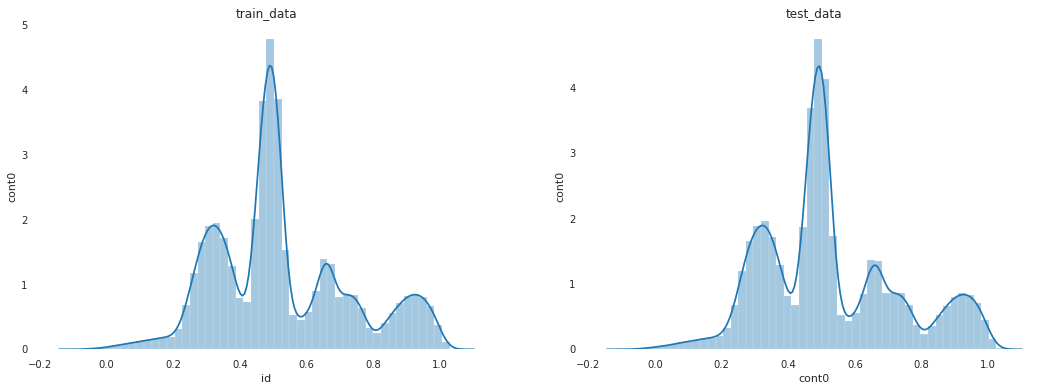

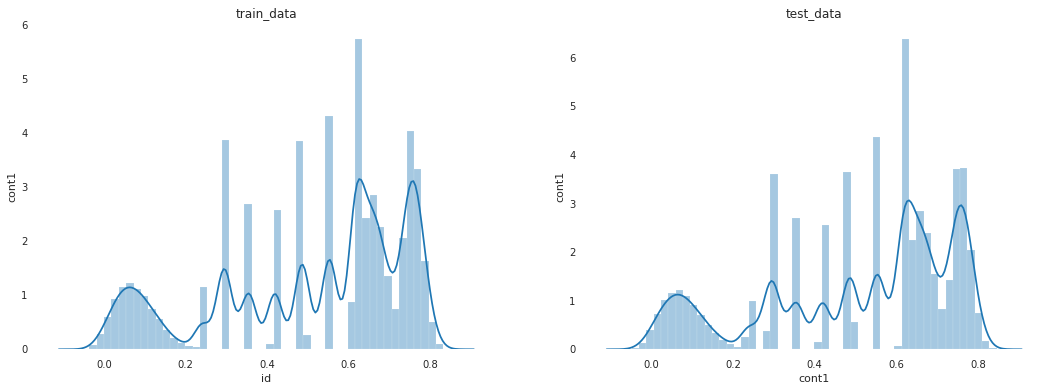

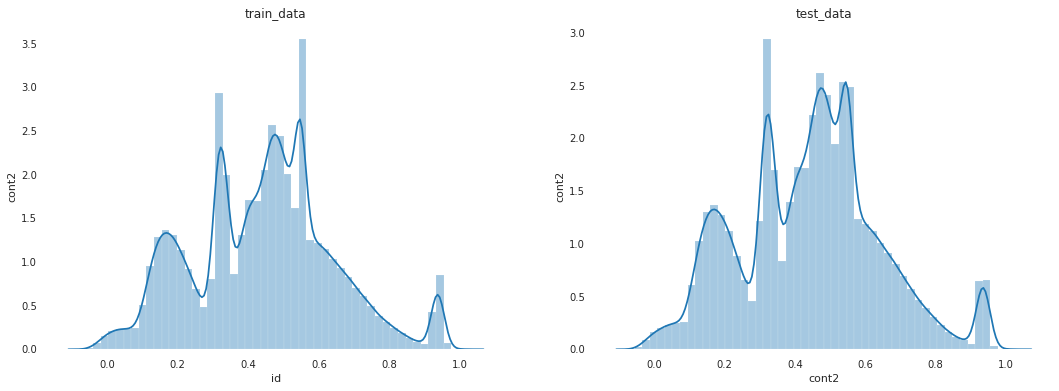

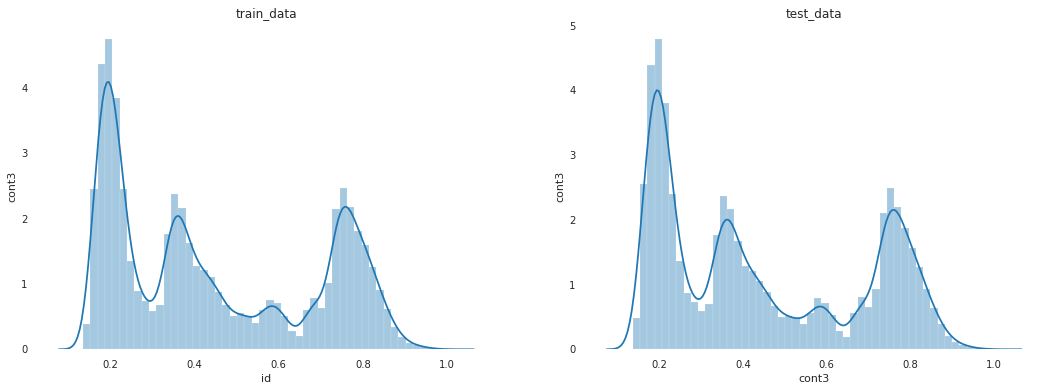

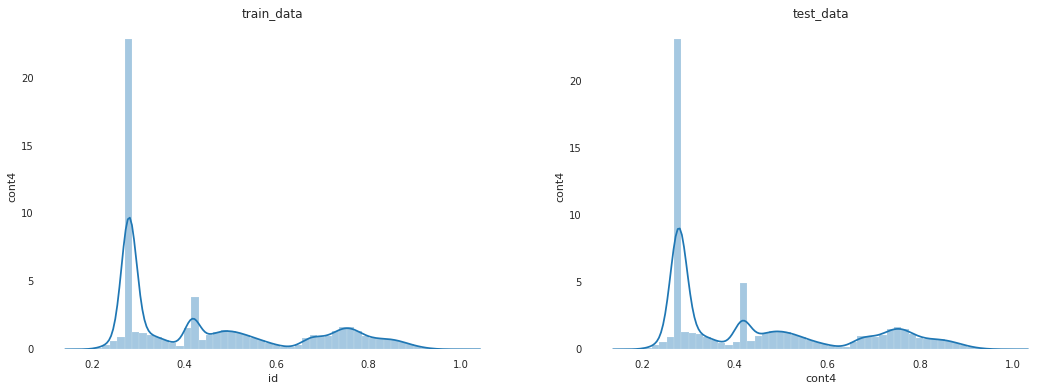

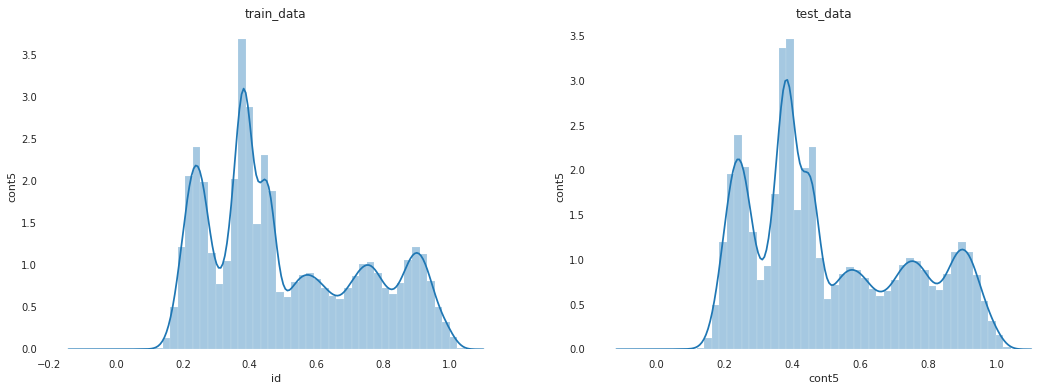

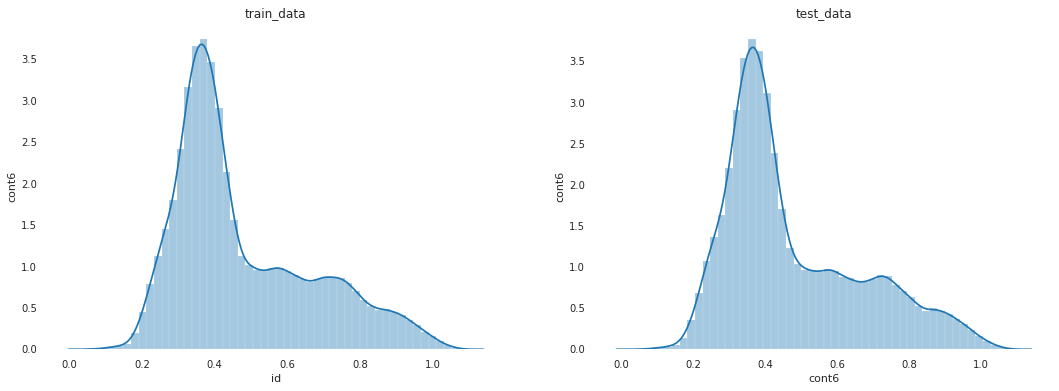

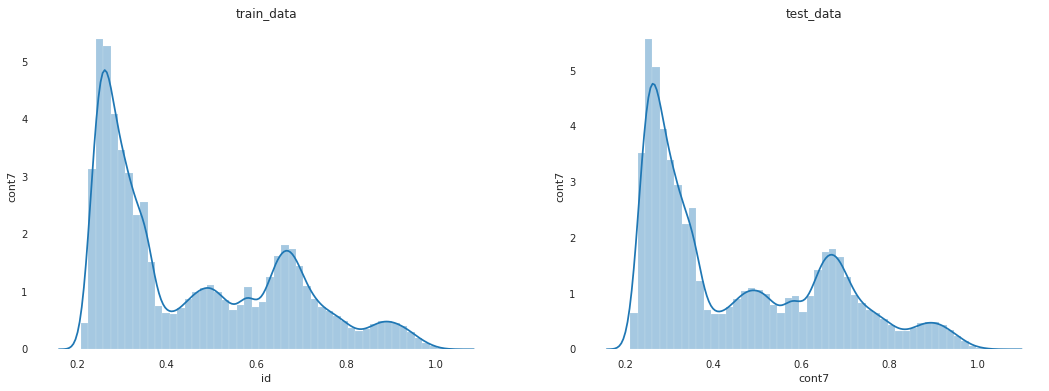

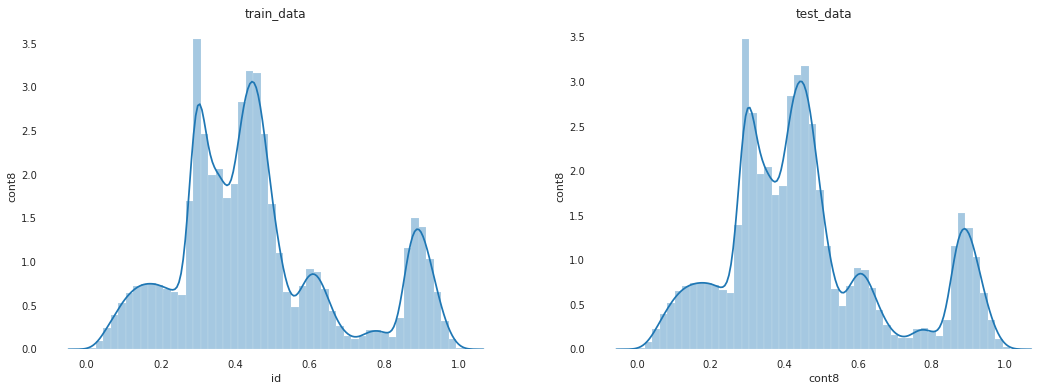

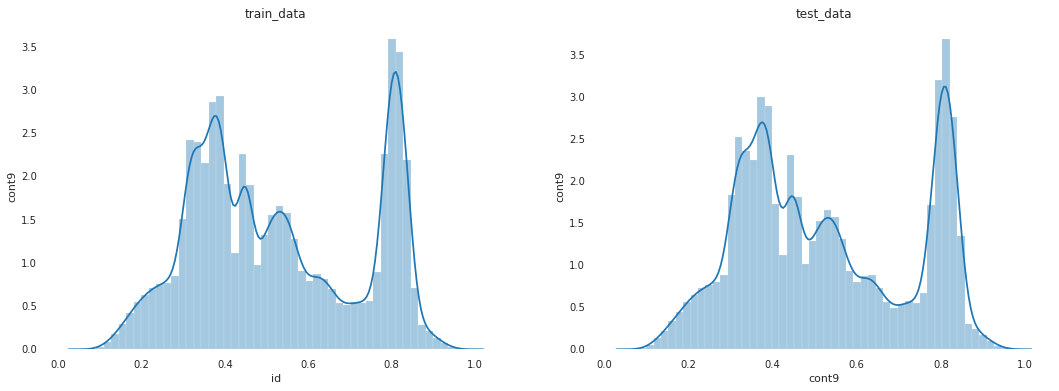

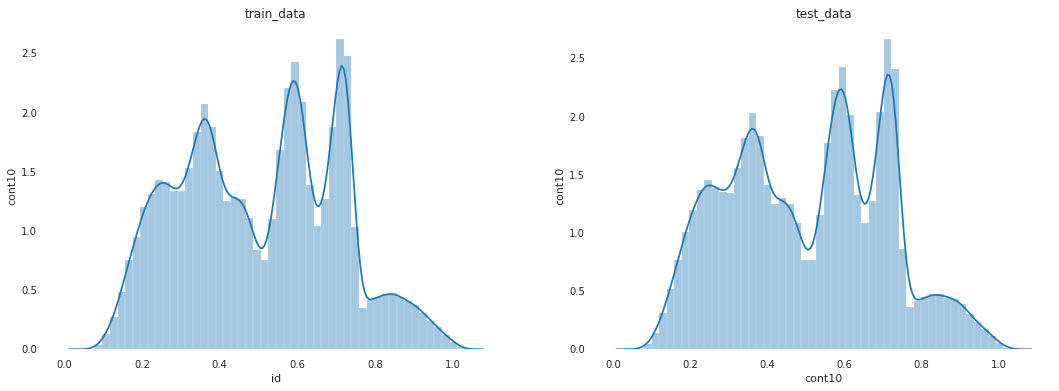

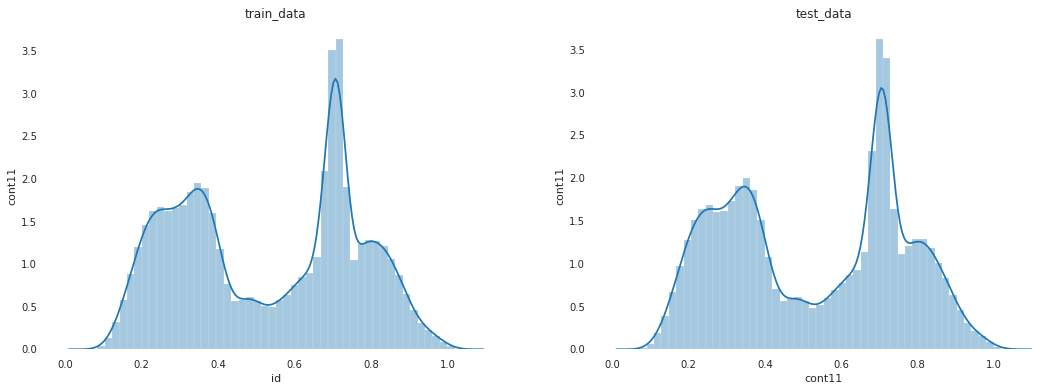

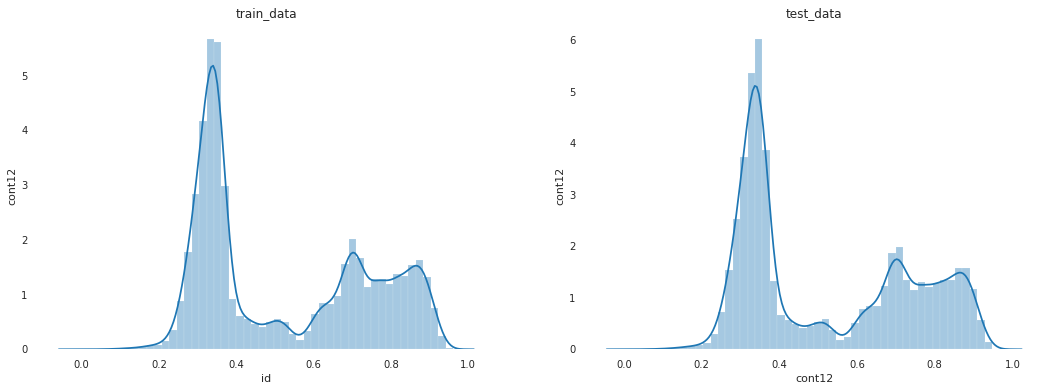

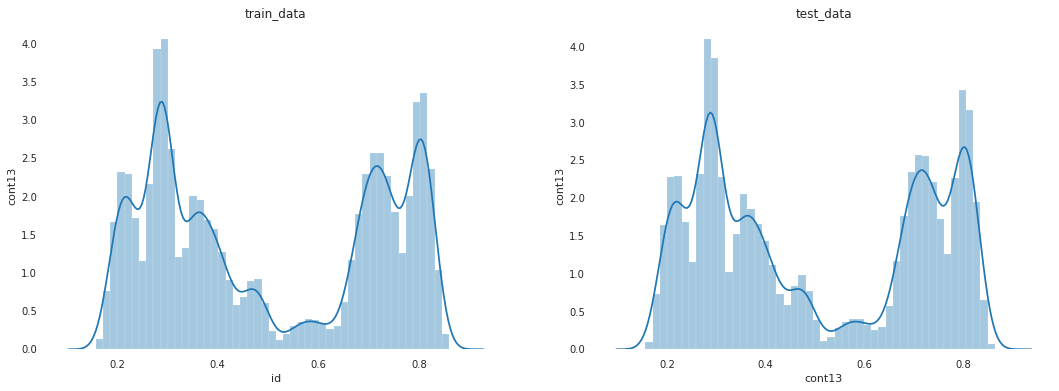

In [12]:
# distribution plot
for i in numerical_features:

    fig, ax = plt.subplots(1,2, figsize=(18,6))

    sns.distplot(a = train_data[i], ax = ax[0])
    ax[0].set(xlabel='id', ylabel=i)
    ax[0].set_title('train_data')

    ax[1].set(xlabel='id', ylabel=i)
    ax[1].set_title("test_data")
    sns.distplot(a = test_data[i], ax = ax[1])

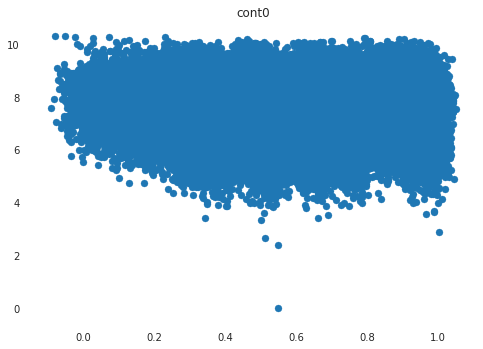

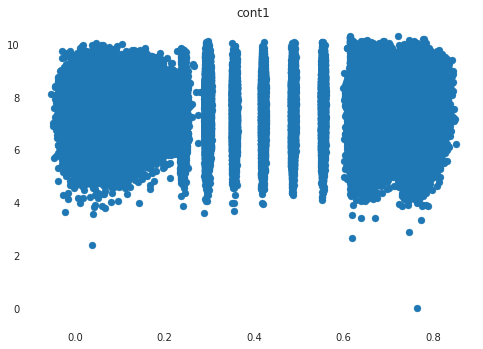

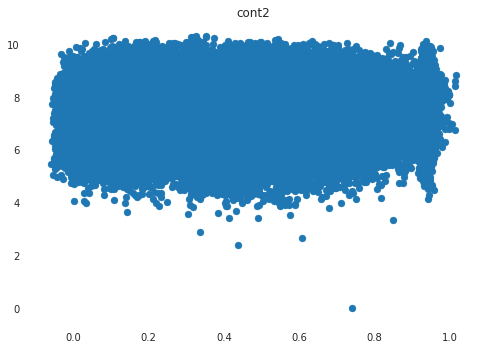

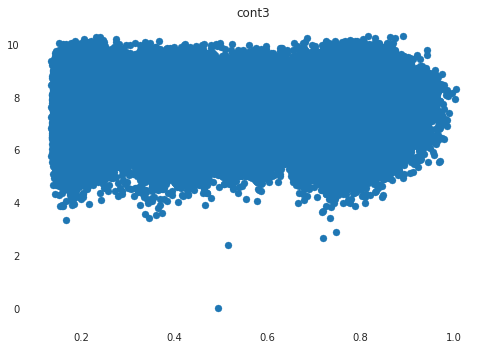

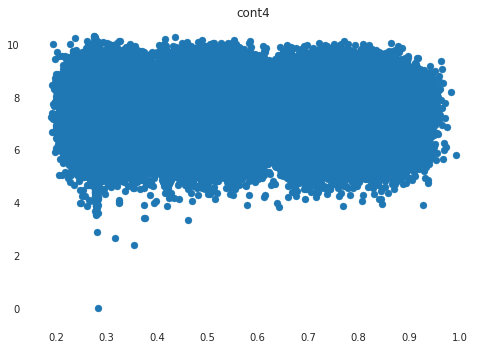

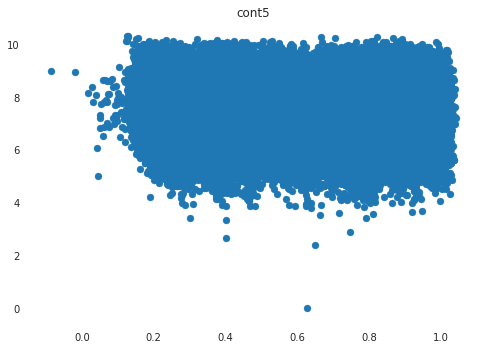

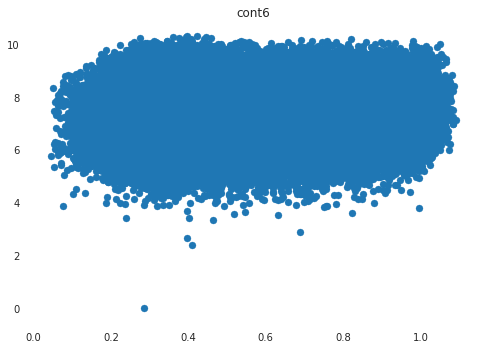

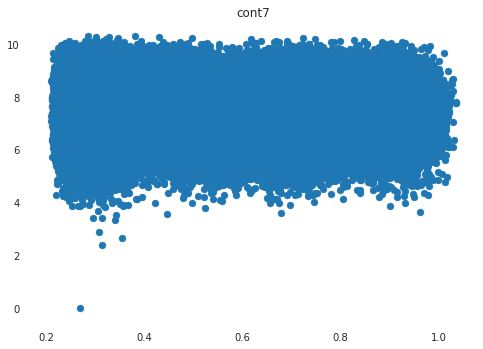

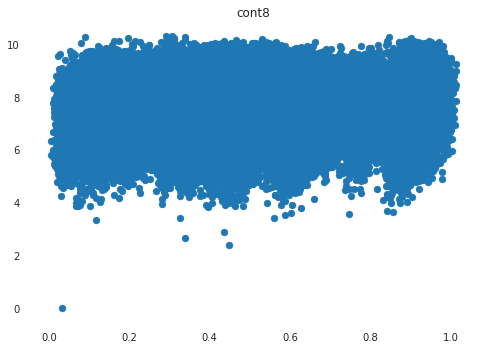

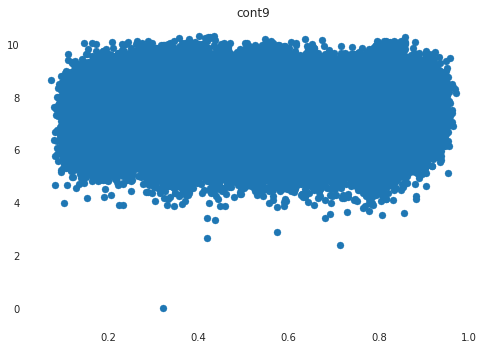

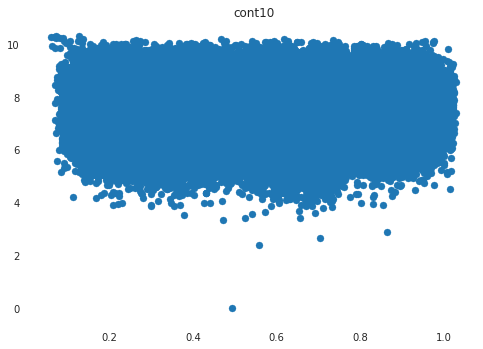

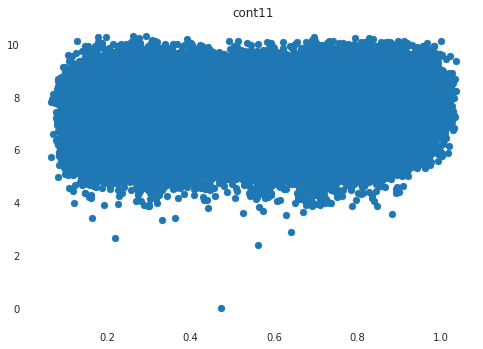

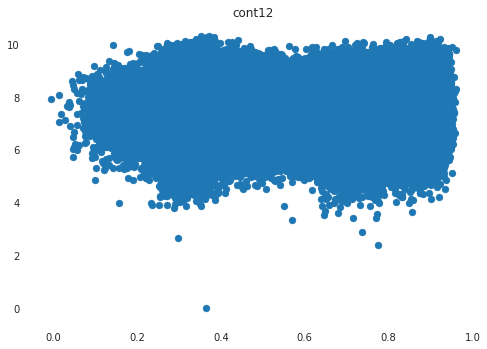

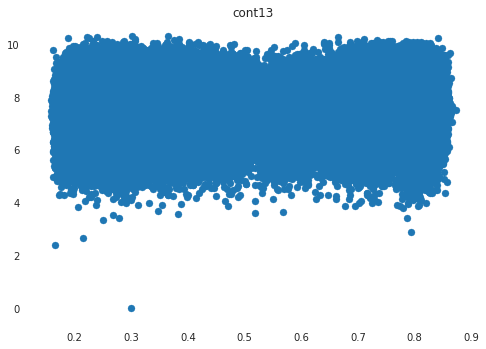

In [21]:
# ploting numerical data vs target
for i in numerical_features:
    fig = plt.figure(figsize=(10,6))
    #train_data.plot(x=i, y="target", style='o')
    plt.scatter(train_data[i], train_data["target"])
    plt.title(i)
    plt.show()


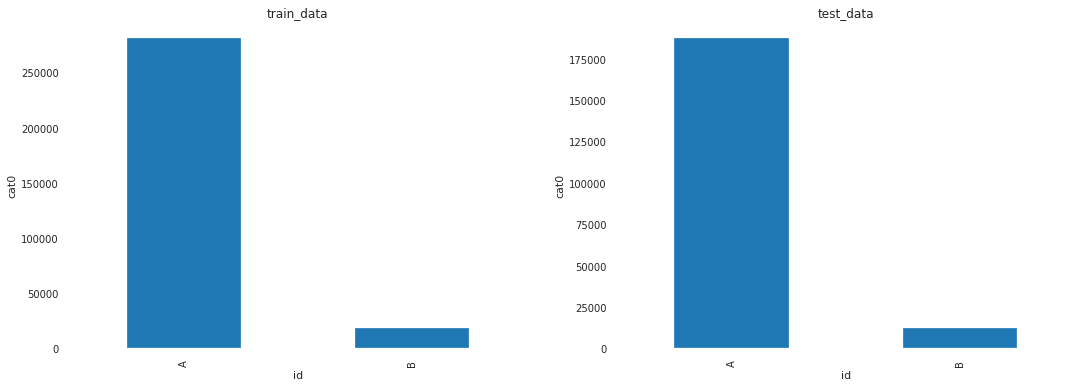

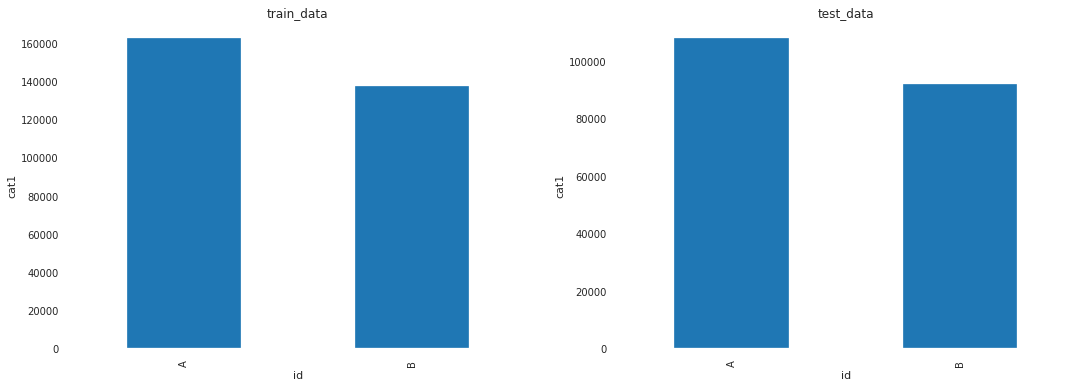

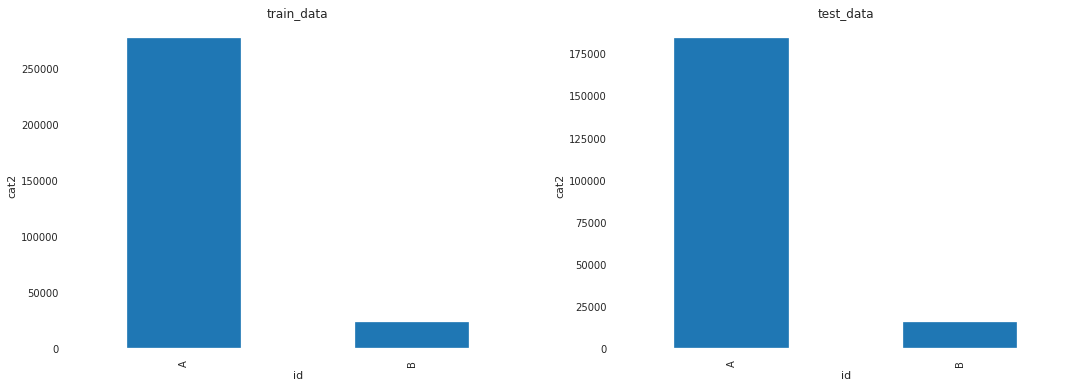

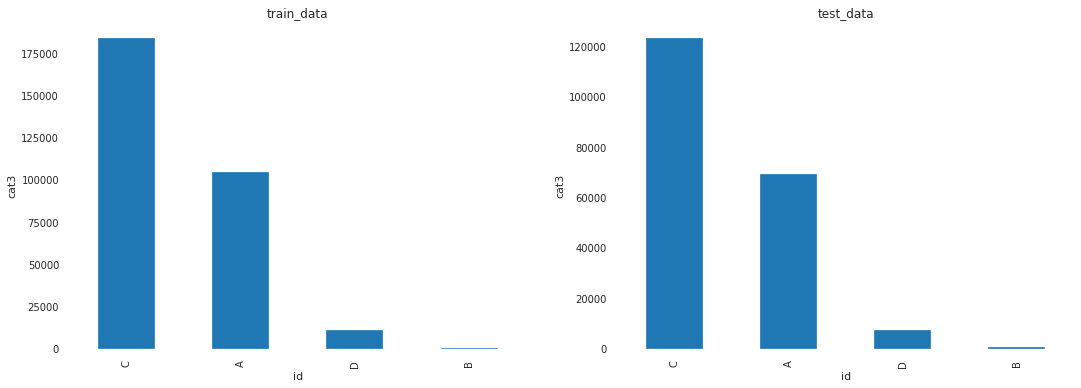

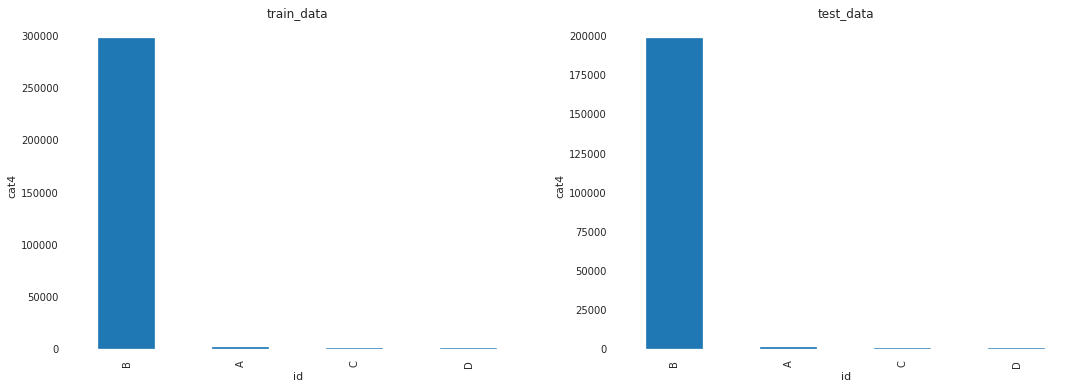

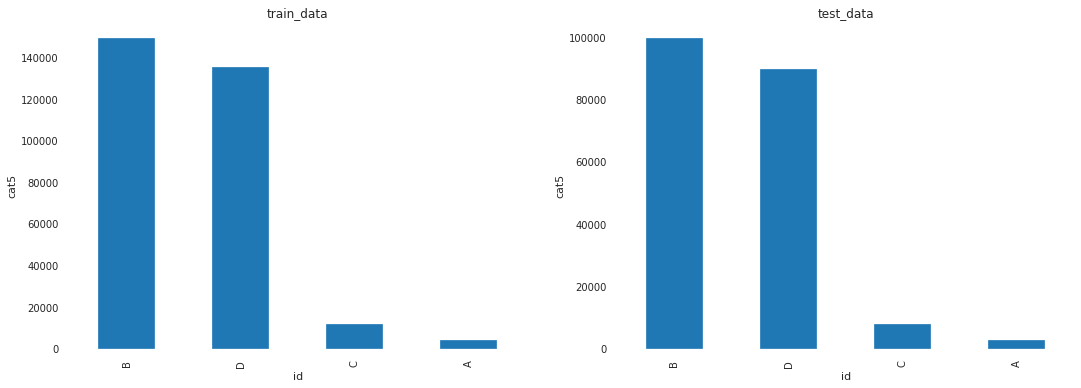

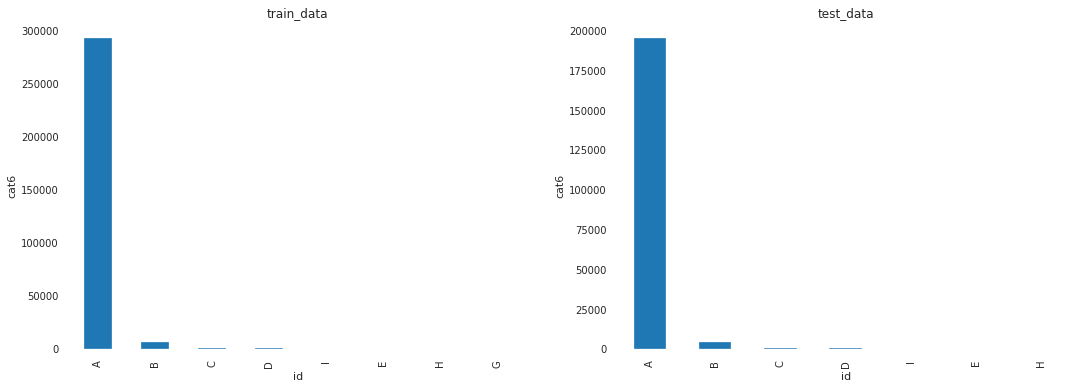

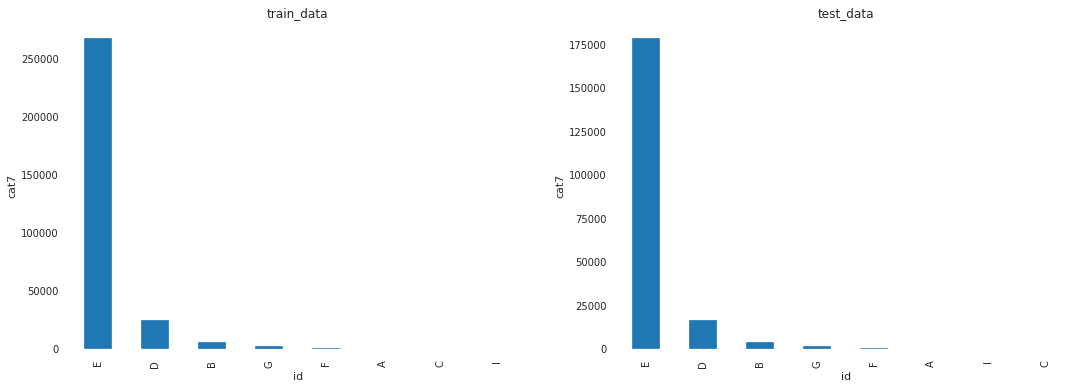

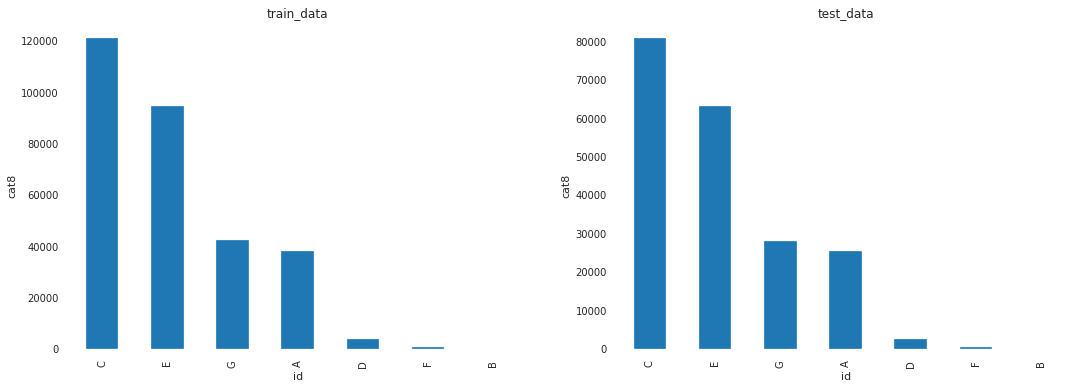

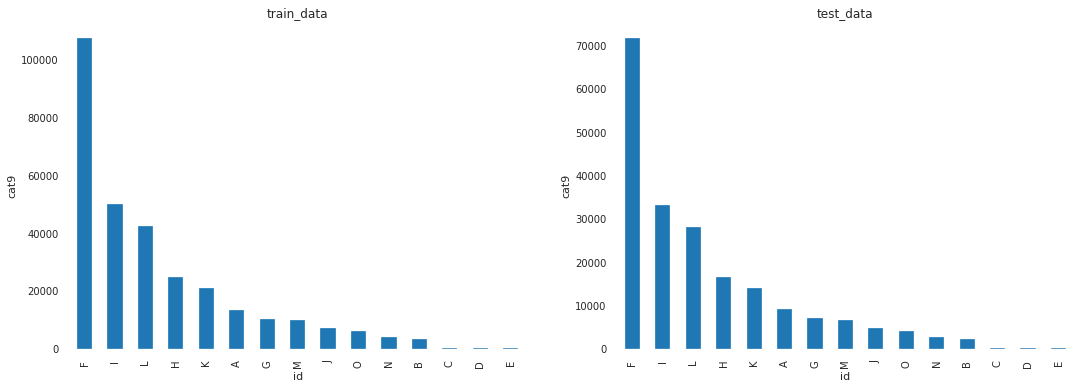

In [23]:
# categorical distribution
for i in cat_features:
    fig, ax = plt.subplots(1,2, figsize=(18,6))
    train_data[i].value_counts().plot(kind = 'bar', ax = ax[0])
    ax[0].set(xlabel='id', ylabel=i)
    ax[0].set_title('train_data')
    ax[1].set(xlabel='id', ylabel=i)
    ax[1].set_title("test_data")
    test_data[i].value_counts().plot(kind = 'bar', ax = ax[1])
    plt.show()

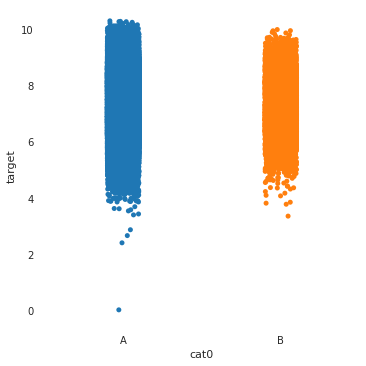

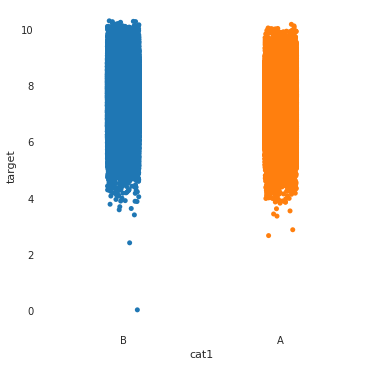

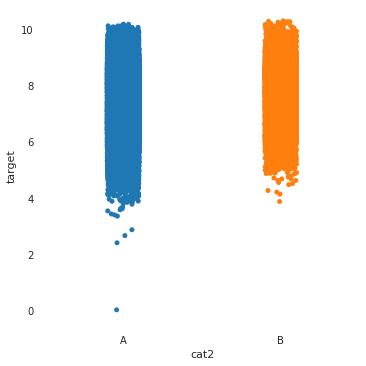

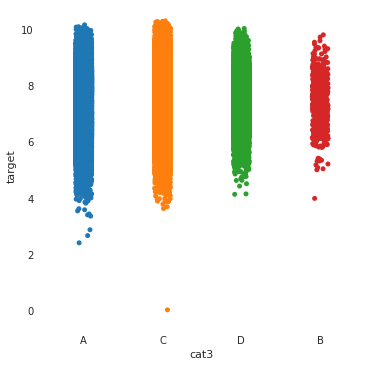

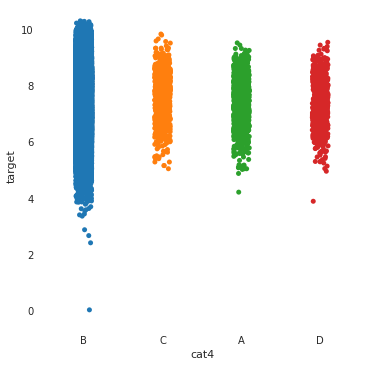

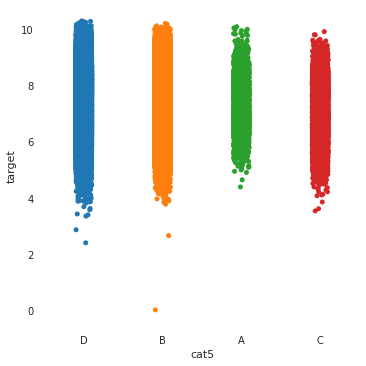

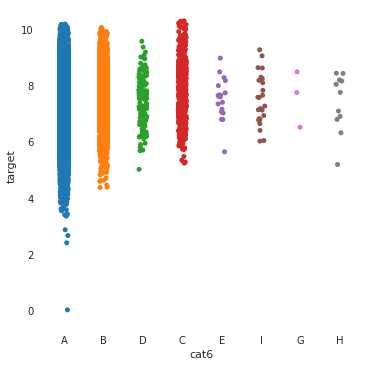

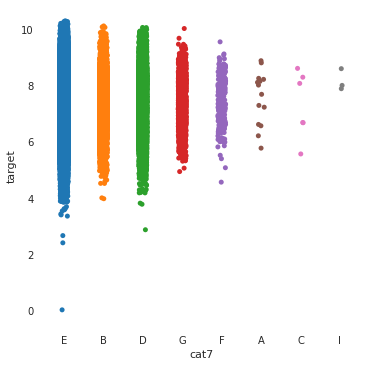

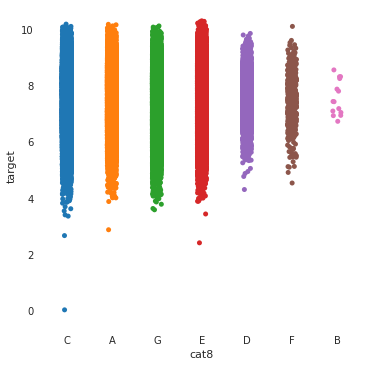

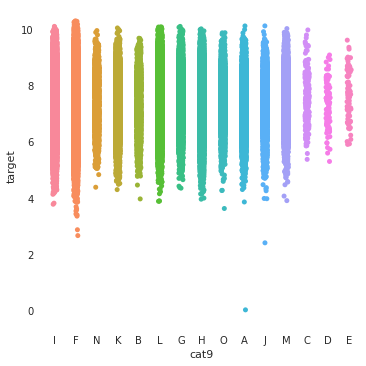

In [24]:
# categorical feature vs target
for i in cat_features:
    sns.catplot(x = i, y="target", data=train_data)
    plt.show()

In [25]:
outlier = train_data.loc[train_data.target < 1.0]
print(outlier, "\n")
print(outlier.index)

           id cat0 cat1 cat2 cat3 cat4 cat5 cat6 cat7 cat8  ...     cont5  \
99682  166042    A    B    A    C    B    B    A    E    C  ...  0.627182   

          cont6    cont7     cont8     cont9    cont10    cont11    cont12  \
99682  0.286103  0.26953  0.031187  0.321662  0.493695  0.474234  0.363619   

         cont13  target  
99682  0.300035     0.0  

[1 rows x 26 columns] 

Int64Index([99682], dtype='int64')


In [26]:
# remove the outlier from the train_data set
train_data.drop([99682], inplace = True)

### Training using CatBoost model

In [27]:
from catboost import CatBoostRegressor

categorical_features = cat_features

y_train = train_data["target"]

train_data.drop(columns = ['target'], inplace = True)


test_data_backup = test_data.copy()

# dropping the id column slightly improves the score
train_data.drop(columns = ["id"], inplace = True)
test_data.drop(columns = ["id"], inplace = True)

model_ctb = CatBoostRegressor(iterations = 3000, 
                               learning_rate = 0.02,
                               od_type = 'Iter',
                               loss_function = 'RMSE',
                               #eval_metric='AUC',
                               grow_policy = 'SymmetricTree',
                               #auto_class_weights = 'Balanced',
                               #max_depth = 8,
                               subsample = 0.8,
                               #colsample_bylevel = 0.9,
                               #l2_leaf_reg = 0.80, 
                               #one_hot_max_size = 4,
                               verbose = 3,
                               random_seed = 17)

model_ctb.fit(train_data, y_train, cat_features=categorical_features)

y_pred = model_ctb.predict(test_data)

print(y_pred)



0:	learn: 0.8865224	total: 374ms	remaining: 18m 41s
3:	learn: 0.8846388	total: 1.19s	remaining: 14m 54s
6:	learn: 0.8829516	total: 1.71s	remaining: 12m 13s
9:	learn: 0.8814614	total: 2.23s	remaining: 11m 5s
12:	learn: 0.8800810	total: 2.78s	remaining: 10m 39s
15:	learn: 0.8787936	total: 3.3s	remaining: 10m 15s
18:	learn: 0.8776181	total: 3.87s	remaining: 10m 7s
21:	learn: 0.8765633	total: 4.4s	remaining: 9m 55s
24:	learn: 0.8755765	total: 5.06s	remaining: 10m 1s
27:	learn: 0.8746888	total: 5.87s	remaining: 10m 22s
30:	learn: 0.8738279	total: 6.5s	remaining: 10m 22s
33:	learn: 0.8730395	total: 7.13s	remaining: 10m 22s
36:	learn: 0.8722584	total: 7.72s	remaining: 10m 18s
39:	learn: 0.8715237	total: 8.28s	remaining: 10m 12s
42:	learn: 0.8708179	total: 8.81s	remaining: 10m 6s
45:	learn: 0.8701757	total: 9.38s	remaining: 10m 2s
48:	learn: 0.8695372	total: 10s	remaining: 10m 2s
51:	learn: 0.8689516	total: 10.5s	remaining: 9m 57s
54:	learn: 0.8683996	total: 11.1s	remaining: 9m 56s
57:	learn: 

In [28]:
solution = pd.DataFrame({"id":test_data_backup.id, "target":y_pred})

solution.to_csv("solution_cat.csv", index = False)

print("saved successful!")


saved successful!
